# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [3]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
from datasets import GtsrbModule

In [5]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [89]:
from models import ResnetModule

In [168]:
from dropblock import DropBlock2D, LinearScheduler

In [114]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

# Datasets

## GTSRB-Normal

In [6]:
dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"

In [7]:
gtsrb_normal_dm = GtsrbModule(data_path=dataset_path, batch_size=1, shuffle=True)

In [8]:
gtsrb_normal_dm.setup(stage='fit')
gtsrb_normal_dm.setup(stage='validate')
gtsrb_normal_dm.setup(stage='test')
print(gtsrb_normal_dm.ds_gtsrb_train)
print(gtsrb_normal_dm.ds_gtsrb_valid)
print(gtsrb_normal_dm.ds_gtsrb_test)

Dataset ImageFolder
    Number of datapoints: 35600
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/train_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fcb156e8810>
Dataset ImageFolder
    Number of datapoints: 3609
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/val_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fcb7b01a450>
Dataset ImageFolder
    Number of datapoints: 1273
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/test_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fcb88d5d210>


In [9]:
gtsrb_normal_train_loader = gtsrb_normal_dm.train_dataloader()
gtsrb_normal_valid_loader = gtsrb_normal_dm.val_dataloader()
gtsrb_normal_test_loader = gtsrb_normal_dm.test_dataloader()
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));

ic| len(gtsrb_normal_train_loader): 35600
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273


In [10]:
dataiter = iter(gtsrb_normal_test_loader)

End of no passing


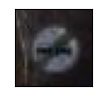

In [11]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

## GTSRB-Anomalies

In [69]:
dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"

In [70]:
gtsrb_anomal_dm = GtsrbModule(data_path=dataset_path, batch_size=1, shuffle=True, anomaly_transforms=True)

In [71]:
gtsrb_anomal_dm.setup(stage='fit')
gtsrb_anomal_dm.setup(stage='validate')
gtsrb_anomal_dm.setup(stage='test')
print(gtsrb_anomal_dm.ds_gtsrb_train)
print(gtsrb_anomal_dm.ds_gtsrb_valid)
print(gtsrb_anomal_dm.ds_gtsrb_test)

Dataset ImageFolder
    Number of datapoints: 35600
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/train_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fcba73b6a50>
Dataset ImageFolder
    Number of datapoints: 3609
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/val_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fcba746ba50>
Dataset ImageFolder
    Number of datapoints: 1273
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/test_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fcba746b8d0>


In [72]:
gtsrb_anomal_train_loader = gtsrb_anomal_dm.train_dataloader()
gtsrb_anomal_valid_loader = gtsrb_anomal_dm.val_dataloader()
gtsrb_anomal_test_loader = gtsrb_anomal_dm.test_dataloader()
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));

ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273


In [73]:
dataiter = iter(gtsrb_anomal_train_loader)

Speed limit (20km/h)


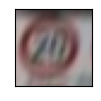

In [87]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

In [88]:
samp.shape

torch.Size([1, 3, 32, 32])

## CIFAR-10 OoD

In [43]:
cifar10_data_dir = "/media/farnez/Data/DATASETS/cifar-10/"

In [44]:
cifar10_dm = CIFAR10DataModule(data_dir=cifar10_data_dir,
                               val_split=0.2,
                               num_workers=10,
                               normalize=True,
                               batch_size=1,
                               seed=10,
                               drop_last=True,
                               shuffle=True)

cifar10_transforms = transform_lib.Compose([
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
])

cifar10_dm.train_transforms = cifar10_transforms
cifar10_dm.test_transforms = cifar10_transforms
cifar10_dm.val_transforms  = cifar10_transforms

In [45]:
cifar10_dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [46]:
cifar10_dm.setup(stage='fit')
cifar10_dm.setup(stage='test')

In [47]:
cifar10_train_loader = cifar10_dm.train_dataloader()
cifar10_valid_loader = cifar10_dm.val_dataloader()
cifar10_test_loader = cifar10_dm.test_dataloader()
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));

ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000


In [48]:
def unprocess_cifar10_image(im,
                            norm_mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                            norm_std=[x / 255.0 for x in [63.0, 62.1, 66.7]], 
                            plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [49]:
dataiter = iter(cifar10_train_loader)

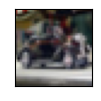

In [59]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_cifar10_image(samp[0], plot=True)

In [60]:
samp.shape

torch.Size([1, 3, 32, 32])

## STL-10 OoD

In [61]:
stl10_data_dir = "/media/farnez/Data/DATASETS/stl-10/"

In [62]:
stl10_dm = STL10DataModule(data_dir=stl10_data_dir,
                           train_val_split=1000,
                           num_workers=10,
                           batch_size=1,
                           seed=10,
                           drop_last=True,
                           shuffle=True)

stl10_transforms = transform_lib.Compose([
    transform_lib.Resize((32, 32)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=(0.43, 0.42, 0.39),
        std=(0.27, 0.26, 0.27)
    )
])

stl10_dm.train_transforms = stl10_transforms
stl10_dm.test_transforms = stl10_transforms
stl10_dm.val_transforms  = stl10_transforms

In [63]:
stl10_dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [64]:
stl10_train_loader = stl10_dm.train_dataloader_labeled()
stl10_valid_loader = stl10_dm.val_dataloader_labeled()
stl10_test_loader = stl10_dm.test_dataloader()
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(stl10_train_loader): 4000
ic| len(stl10_valid_loader): 1000
ic| len(stl10_test_loader): 8000


In [221]:
def unprocess_stl10_image(im,
                          norm_mean=[0.43, 0.42, 0.39],
                          norm_std=[0.27, 0.26, 0.27], 
                          plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [222]:
dataiter = iter(stl10_train_loader)

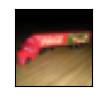

In [249]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_stl10_image(samp[0], plot=True)

# GTSRB ResNet18 Classifier

In [90]:
gtsrb_model_path = "/home/farnez/Projects/GTSRB-Classifier/lightning_logs/2023-05-08_00-26-01/epoch=1164-step=325035.ckpt"
gtsrb_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_model_path)

In [92]:
gtsrb_model

ResnetModule(
  (loss_fn): FocalLoss()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [94]:
gtsrb_model.eval();

# Add Hook

We add 2 Hooks:

1. In the dropblock2d layer (after applying dropout to the)
2. In the fc (after applying a linear transformation to the output of the dropblock2d layer)

In [99]:
ic(gtsrb_model.model.dropblock2d.dropblock);
ic(gtsrb_model.model.dropblock2d.dropblock.drop_prob);
ic(gtsrb_model.model.dropblock2d.dropblock.training);

ic| gtsrb_model.model.dropblock2d.dropblock: DropBlock2D()
ic| gtsrb_model.model.dropblock2d.dropblock.drop_prob: 0.4
ic| gtsrb_model.model.dropblock2d.dropblock.training: False


In [101]:
ic(gtsrb_model.model.dropout_layer);
ic(gtsrb_model.model.dropout_layer.p);
ic(gtsrb_model.model.dropout_layer.training);

ic| gtsrb_model.model.dropout_layer: Dropout(p=0.4, inplace=False)
ic| gtsrb_model.model.dropout_layer.p: 0.4
ic| gtsrb_model.model.dropout_layer.training: False


In [102]:
ic(gtsrb_model.model.fc);

ic| gtsrb_model.model.fc: Linear(in_features=512, out_features=43, bias=True)


## Hook DropBlock2D Layer

In [213]:
# gtsrb_model_dropblock2d_layer_hook = Hook(gtsrb_model.model.dropblock2d.dropblock)
# gtsrb_model_dropblock2d_layer_hook = Hook(gtsrb_model.model.dropblock2d)
gtsrb_model_dropblock2d_layer_hook = Hook(gtsrb_model.model.layer4)

## Hook FC Layer

In [105]:
gtsrb_model_fc_layer_hook = Hook(gtsrb_model.model.fc)

# Get Monte-Carlo Samples

In [214]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [215]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def resnet18_enable_dropblock2d_test(m):
    if type(m) == DropBlock2D or type(m) == LinearScheduler:
        m.train()

In [216]:
mc_samples = 32

In [217]:
gtsrb_model.to(device);
gtsrb_model.eval(); 
gtsrb_model.apply(resnet18_enable_dropblock2d_test); # enable dropout

In [218]:
ic(gtsrb_model.model.dropblock2d);
ic(gtsrb_model.model.dropblock2d.training);
ic("=======")
ic(gtsrb_model.model.dropblock2d.dropblock);
ic(gtsrb_model.model.dropblock2d.dropblock.drop_prob);
ic(gtsrb_model.model.dropblock2d.dropblock.training);
ic("=======")
ic(gtsrb_model.model.dropout_layer);
ic(gtsrb_model.model.dropout_layer.p);
ic(gtsrb_model.model.dropout_layer.training);

ic| gtsrb_model.model.dropblock2d: LinearScheduler(
                                     (dropblock): DropBlock2D()
                                   )
ic| gtsrb_model.model.dropblock2d.training: True
ic| '======='
ic| gtsrb_model.model.dropblock2d.dropblock: DropBlock2D()
ic| gtsrb_model.model.dropblock2d.dropblock.drop_prob: 0.4
ic| gtsrb_model.model.dropblock2d.dropblock.training: True
ic| '======='
ic| gtsrb_model.model.dropout_layer: Dropout(p=0.4, inplace=False)
ic| gtsrb_model.model.dropout_layer.p: 0.4
ic| gtsrb_model.model.dropout_layer.training: False


In [219]:
ic(gtsrb_model.model.dropblock2d.drop_values.shape);
ic(gtsrb_model.model.dropblock2d.drop_values);

ic| gtsrb_model.model.dropblock2d.drop_values.shape: (25000,)
ic| gtsrb_model.model.dropblock2d.drop_values: array([0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4])


In [220]:
drop_values_new = np.ones(25000) * 0.4
ic(drop_values_new.shape);
ic(drop_values_new);

ic| drop_values_new.shape: (25000,)
ic| drop_values_new: array([0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4])


In [221]:
gtsrb_model.model.dropblock2d.drop_values = drop_values_new

In [222]:
ic(gtsrb_model.model.dropblock2d.drop_values.shape);
ic(gtsrb_model.model.dropblock2d.drop_values);

ic| gtsrb_model.model.dropblock2d.drop_values.shape: (25000,)
ic| gtsrb_model.model.dropblock2d.drop_values: array([0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4])


In [120]:
gtsrb_resnet_gtsrb_normal_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                                gtsrb_normal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [223]:
gtsrb_resnet_gtsrb_normal_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                               gtsrb_normal_test_loader,
                                                                               1,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=False)

In [122]:
gtsrb_resnet_gtsrb_anomal_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                                gtsrb_anomal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [123]:
gtsrb_resnet_gtsrb_anomal_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                               gtsrb_anomal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

In [124]:
torch.save(gtsrb_resnet_gtsrb_normal_valid_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_normal_valid_32mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_normal_test_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_normal_test_32mc_samples.pt')

torch.save(gtsrb_resnet_gtsrb_anomal_valid_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_anomal_valid_32mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_anomal_test_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_anomal_test_32mc_samples.pt')

In [224]:
gtsrb_resnet_gtsrb_normal_test_32mc_samples.shape

torch.Size([1273, 512, 1, 1])

In [206]:
gtsrb_resnet_gtsrb_normal_test_32mc_samples[0].shape

torch.Size([512, 1, 1])

In [226]:
gtsrb_resnet_gtsrb_normal_test_32mc_samples.shape

torch.Size([1273, 512, 1, 1])

# Get Entropy

In [125]:
_, gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_valid_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 512)


In [126]:
_, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_test_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 512)


In [129]:
_, gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_valid_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 512)


In [130]:
_, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_test_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 512)


In [131]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_test_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np)

# Entropy 2D Projection

(7218, 512)
(7218, 1)


/home/farnez/.virtualenvs/Semantic_Segmentation/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/home/farnez/.virtualenvs/Semantic_Segmentation/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


(7218, 2)


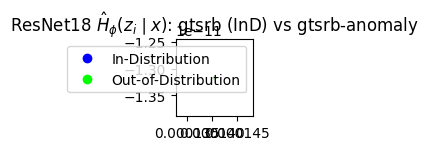

In [132]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np,
                    neighbors=14,
                    title="ResNet18 $\hat{H}_{\phi}(z_i \mid x)$: gtsrb vs gtsrb-anomaly")